**The QOSF screening task challenge**

Build a ZNE function

1. Build a simple noise model with depolarising noise
2. Create different circuits to test your noise model. Choose an observable to measure. 
3. Apply the unitary folding method
4. Apply an extrapolation method to get the zero-noise limit. Try linear, polynomial, and exponential
5. Compare your noise mitigated and unmitigated results
6. Run your ZNE function on real quantum hardware

**Introduction**

This Jupyter notebook contains code that achieves these points with comments/explanations. The subtasks (i.e., 1., 2., ...) will be clearly highlighted. 

The ZNE function here is a **global circuit-based unitary folding**, wherein the entire circuit is folded $\lambda$ times.

# Contents: 

## Section A: Circuit and simulation preliminaries

Importing libraries and setting parameters for simulation

## Section B: Creating the original circuit

We follow Randomised Benchmarking Protocol to generate a quantum circuit

*Corresponds to subtask 2.* 

## Section C: Creating the inverse of the original circuit

We used an in-built inversion method to generate an inverted circuit.

*Corresponds to subtask 3.* 

## Section D: Perform a density matrix simulation to obtain the ideal `noiseless' result

We state that the observable is the expectation value of the generalised n-qubit '|0>' state. If numqubits = 3, then we seek the expectation value of |000>. 

According to the Randomised Benchmarking Protocol, the ideal expectation value in the case of a noiseless simulation to obtain '|0>' is 1 and the expectation value of obtaining any other result is 0. 

Ultimately, this step is optional. 

## Section E: Create a noise model

For this task, we create a depolarising channel for each gate on all qubits with probability 'depolarising_prob' 

*Corresponds to subtask 1.*

## Section F: Perform a series of noisy simulations using that noise model

We create the method 'generate_folded_circuit' to generate a $\lambda$-times folded circuit. This uses **global circuit-based folding**.

$\lambda$ takes on the only odd integer values for now, for simplicity. The expectation value is stored in 'measured_values_array'.

*Corresponds to subtask 3.* 

## Section G: Perform linear, polynomial, and exponential extrapolation

By default, the polynomial result is Richardson extrapolation, which fits a polynomial one order lower than the number of available datapoints. Any general polynomial fit is possible. Be aware that high-order polynomial fitting can lead to 'overfitting' if the underlying data are noisy and there are too many data points. 

This will plot the 'ideal' result, the noisy results, the fits, and the extrapolated noise-free result on a figure. 

*Corresponds to subtasks 4 and 5*

## Section A: Circuit and simulation preliminaries

Importing libraries and setting parameters for simulation

In [1]:
import qiskit
from qiskit import QuantumRegister, QuantumCircuit
from qiskit_experiments.library import StandardRB, InterleavedRB # Used to generate a random original circuit as per the Randomized Benchmarking Protocol
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment # Used to generate a random original circuit as per the Randomized Benchmarking Protocol
import qiskit.circuit.library as circuits # Used to generate a random original circuit as per the Randomized Benchmarking Protocol
from qiskit.transpiler.passes import RemoveFinalMeasurements # Removes the final measurement from Randomized Benchmarking
from qiskit.converters import circuit_to_dag, dag_to_circuit # Used for manual inversion 
from qiskit_aer import AerSimulator # This is the simulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error # This is the noise model
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit import transpile
from qiskit.visualization import plot_distribution # For visualisation
import numpy as np # For arrays
from scipy.optimize import curve_fit # For curve-fitting
import matplotlib.pyplot as plt # For showing the ZNE plots

In [2]:
## Overall ZNE parameters

## Circuit parameters
numqubits = 2 # number of qubits in the quantum circuit
circuit_depth = 10 # depth of circuit. 

## Simulation parameters
numshots = 10000 # The simulator will run 10,000 shots, for example, to build the expectation value

## Observable is |0> for n qubits. 
# This method creates a string of "0" n times. Will use this to extract the observable of interest. 
target_value = ""
for index in range(numqubits):
    target_value += "0"
print("Will read the expectation value of \"|" + target_value + ">\"")

Will read the expectation value of "|00>"


## Section B: Creating the original circuit

We follow Randomised Benchmarking Protocol to generate a quantum circuit

**Corresponds to subtask 2.** 

In [3]:
## Defining a quantum circuit consisting of
## only a barrier for aesthetic convenience

q0 = QuantumRegister(numqubits, name = 'q0')
qc0 = QuantumCircuit(q0, name = 'qc0') # exists solely to add barriers. 

qc0.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q0'), 0), Qubit(QuantumRegister(2, 'q0'), 1)), clbits=())

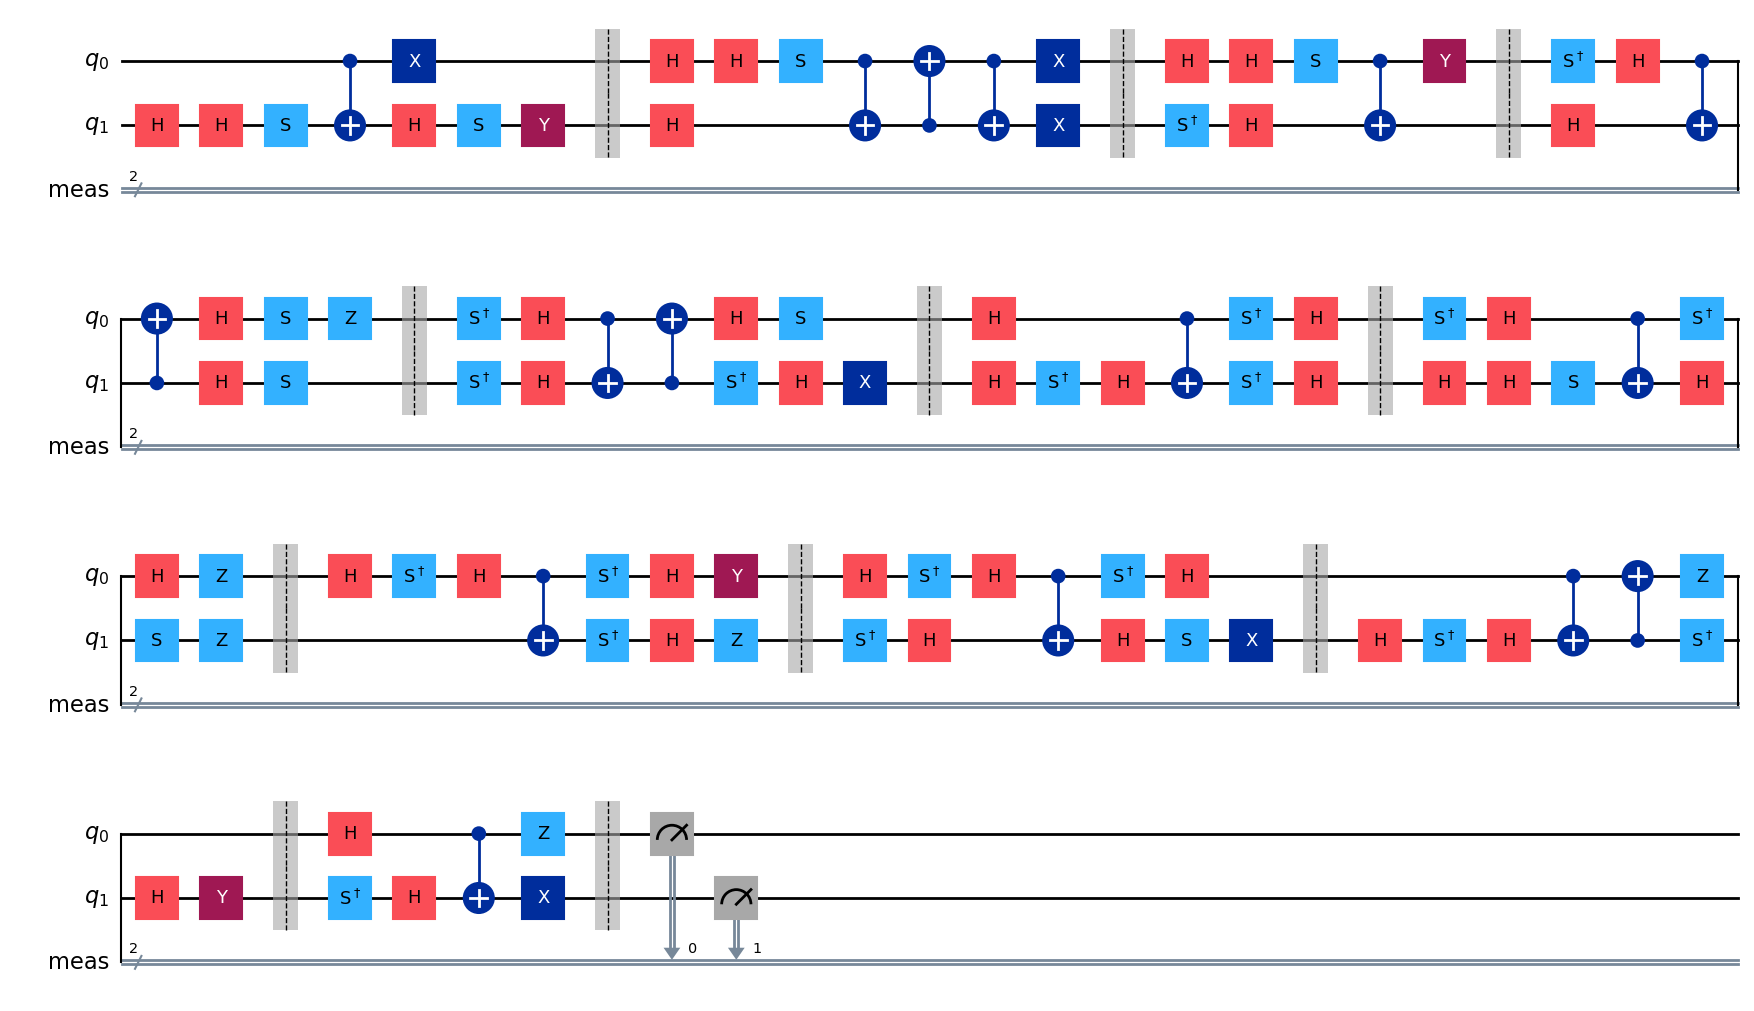

In [4]:
lengths = np.array([circuit_depth]) # This circuit has depth=circuit_depth
num_samples = 1 # Just want one circuit
seed = 101 # Some random seed. 
qubits = []
for index in range(numqubits):
    qubits.append(index);

exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
original_circuit = exp1.circuits()[0]
original_circuit.decompose().draw(output="mpl", style="iqp") 

# The expectation value of the output quantum state is |00>
# Important to emphasise: We do not use StandardRB to simulate the circuit. 

In [5]:
## For folding, we must remove the measurement at the end. 

q1 = QuantumRegister(numqubits, name = 'q1')
qc1 = QuantumCircuit(q1, name = 'qc1')

## Decompose the original circuit into layers
dag = circuit_to_dag(original_circuit)
remove_final_meas = RemoveFinalMeasurements() # Removes the measurement at the end. 
remove_final_meas.run(dag)

qc1 = dag_to_circuit(dag).copy()
original_circuit = qc1.copy() # Deep copy. 

## Section C: Creating the inverse of the original circuit

We used an in-built inversion method to generate an inverted circuit.

*Corresponds to subtask 3.* 

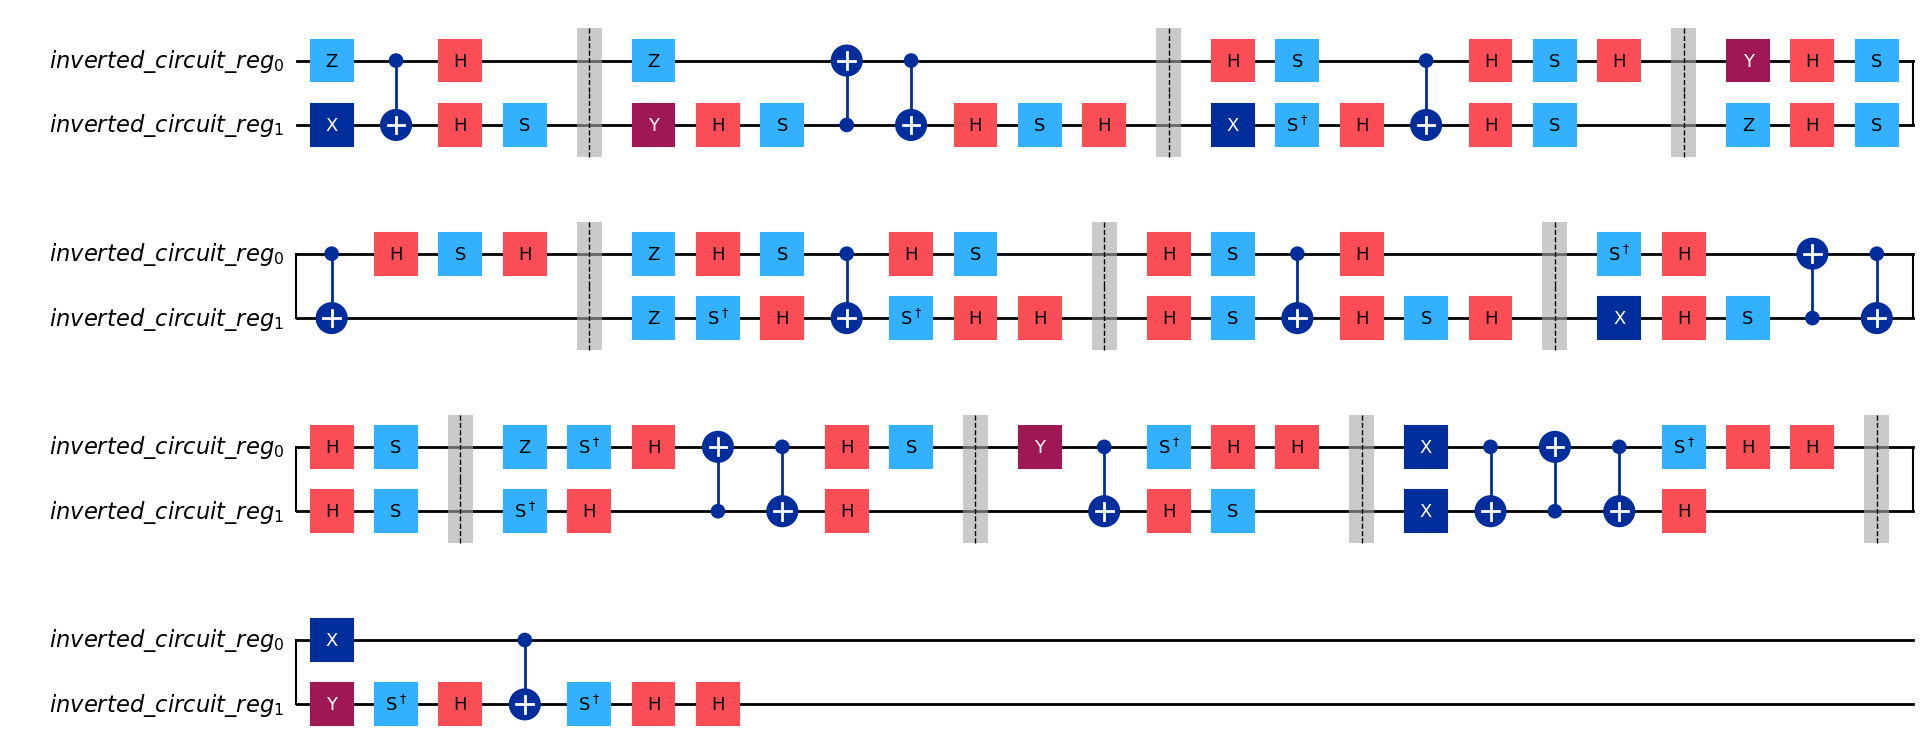

In [6]:
## Decompose the original circuit into layers
dag = circuit_to_dag(original_circuit)

# Create a reversed version of the original circuit
temp = reversed(list(dag.layers()))

## Create a blank quantum circuit that will store the inverted version of the original circuit
inverted_circuit_reg = QuantumRegister(numqubits, name='inverted_circuit_reg')
inverted_circuit = QuantumCircuit(inverted_circuit_reg, name = 'inverted_circuit')

# Iterate through the reversed circuit
# to insert the original circuit into the new circuit
for temp2 in temp:

    layer_as_circuit = dag_to_circuit(temp2['graph']).inverse()
    inverted_circuit = inverted_circuit.compose(layer_as_circuit)

inverted_circuit.decompose().draw('mpl')

## Section D: Perform a density matrix simulation to obtain the ideal `noiseless' result

We state that the observable is the expectation value of the generalised n-qubit '|0>' state. If numqubits = 3, then we seek the expectation value of |000>. 

According to the Randomised Benchmarking Protocol, the ideal expectation value in the case of a noiseless simulation to obtain '|0>' is 1 and the expectation value of obtaining any other result is 0. 

Ultimately, this step is optional. 

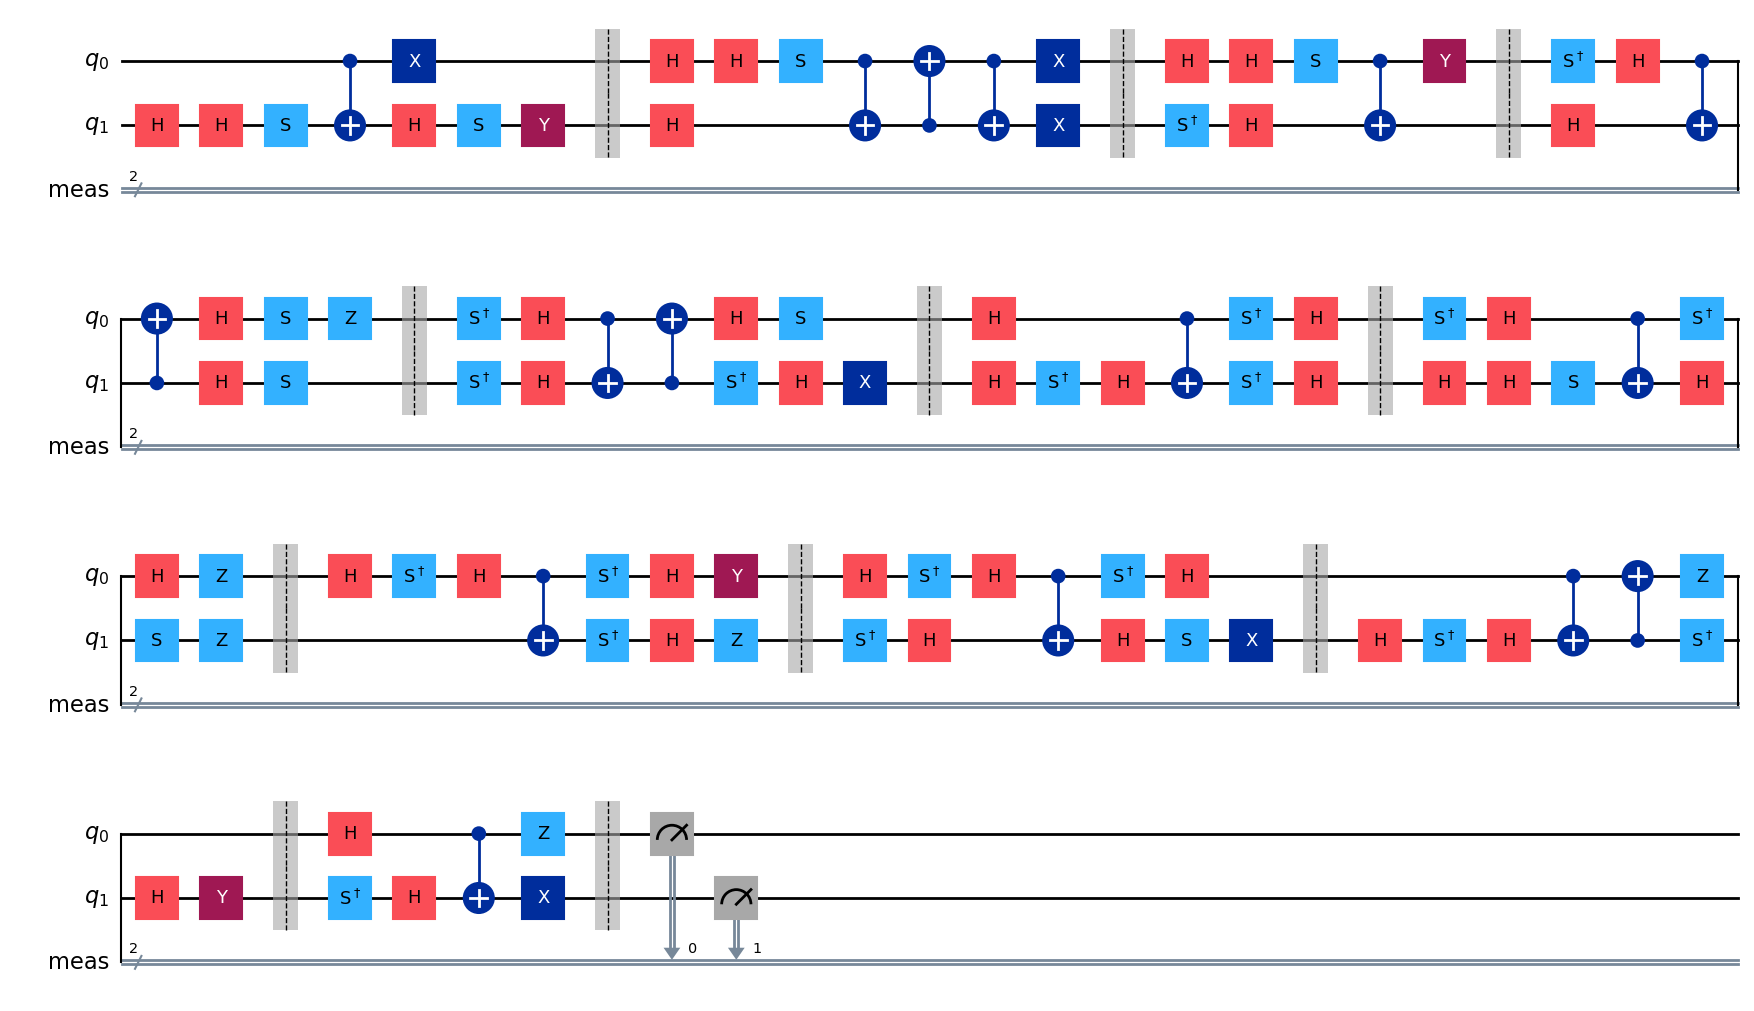

In [7]:
q_ideal = QuantumRegister(numqubits, name = 'q_ideal')
qc_ideal = QuantumCircuit(q_ideal, name = 'q_ideal')
qc_ideal = original_circuit.copy() # deep copy to q_ideal.
qc_ideal.measure_all()
qc_ideal.decompose().draw('mpl')

In [8]:
# Construct an ideal (i.e., noiseless) simulator
sim_ideal = AerSimulator(method='density_matrix')

# Perform an ideal (i.e., noiseless) simulation
result = sim_ideal.run(transpile(qc_ideal, sim_ideal), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Ideal counts for my circuit')

ideal_val = result.get_counts(0)[target_value]
print("Probability of observing the state |" + target_value + "> is: " + str(ideal_val/numshots))

Probability of observing the state |00> is: 1.0


## Section E: Create a noise model

For this task, we create a depolarising channel for each gate on all qubits with probability 'depolarising_prob' 

*Corresponds to subtask 1.*

In [9]:
# Find all unique gates in original_circuit
gate_list = [];
for gate in original_circuit.decompose().data:
    word = gate[0].name
    if word not in gate_list:
        if word == 'measure':
            continue
        gate_list.append(word)
print(gate_list)

['h', 's', 'cx', 'x', 'y', 'barrier', 'sdg', 'z']


In [10]:
## Create a simple depolarising noise model
# All gates suffer from depolarising noise uniformly
noise_model = NoiseModel()

depolarising_prob = 0.01; # Probability of depolarising noise occurring for each gate for each qubit. 

In [11]:
# Add depolarizing error to all single qubit gates
error = depolarizing_error(depolarising_prob, 1)
cx_error = depolarizing_error(depolarising_prob, 2) # CNOT errors
ccx_error = depolarizing_error(depolarising_prob, 3) # CCNOT errors

for gate in gate_list:
    if gate == 'cx' or gate == 'cz' or gate =='dcx' or gate == 'swap':
        noise_model.add_all_qubit_quantum_error(cx_error, ["cx"])
        continue;
    if gate == 'ccx':
        noise_model.add_all_qubit_quantum_error(ccx_error, ["ccx"])
        continue;
    noise_model.add_all_qubit_quantum_error(error, [gate])

print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 's', 'sdg', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['y', 'barrier', 'sdg', 'z', 'cx', 'h', 'x', 's']
  All-qubits errors: ['h', 's', 'cx', 'x', 'y', 'barrier', 'sdg', 'z']


## Section F: Perform a series of noisy simulations using that noise model

We create the method 'generate_folded_circuit' to generate a $\lambda$-times folded circuit. This uses **global circuit-based folding**.

$\lambda$ takes on the only odd integer values for now, for simplicity. The expectation value is stored in 'measured_values_array'.

*Corresponds to subtask 3.* 

In [12]:
def generate_folded_circuit(lambda_value,original_circuit, inverse_circuit, final_circuit, barrier_circuit):

    if not(isinstance(lambda_value, int)):
        print("Lambda_value is not an integer. Please enter an integer. ")
        return final_circuit;
    if not(lambda_value % 2):
        print("Lambda_value is not an odd integer. Please enter an odd integer. ")
        return final_circuit;
    if lambda_value == 1:
        final_circuit = final_circuit.compose(original_circuit); # The "folded" circuit is just the original.
        final_circuit.measure_all(); # We assume that the final_circuit object is empty. 
        return final_circuit;
    
    
    final_circuit = final_circuit.compose(original_circuit) # Original circuit. 
    
    ## Repeat the original & inverse circuit pairs for lambda
    for index in range(round((lambda_value-1)/2)):
        final_circuit = final_circuit.compose(barrier_circuit)
        final_circuit = final_circuit.compose(inverse_circuit)
        final_circuit = final_circuit.compose(barrier_circuit)
        final_circuit = final_circuit.compose(original_circuit)
    
    final_circuit.measure_all()
    return final_circuit;

In [13]:
## Perform a series of at least 2 noisy simulations. 
lambda_value_array = [1, 3,5];
measured_values_array = [];
#measured_values_array.append(ideal_val/numshots)


for value in lambda_value_array:
    q3 = QuantumRegister(numqubits, name='q3')
    qc3 = QuantumCircuit(q3, name = 'qc3')
    qc3 = generate_folded_circuit(value, original_circuit, inverted_circuit, qc3, qc0)
    
    # Perform a noisy simulation
    sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')
    
    result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
    counts = result.get_counts(0)
    #plot_distribution(counts, title='Noisy counts for my circuit')
    noisy_val = result.get_counts(0)[target_value]
    print("Probability of observing the state |" + target_value + "> is: " + str(noisy_val/numshots))
    measured_values_array.append(noisy_val/numshots)
    

Probability of observing the state |00> is: 0.6181
Probability of observing the state |00> is: 0.3406
Probability of observing the state |00> is: 0.2825


## Section G: Perform linear, polynomial, and exponential extrapolation

By default, the polynomial result is Richardson extrapolation, which fits a polynomial one order lower than the number of available datapoints. Any general polynomial fit is possible. Be aware that high-order polynomial fitting can lead to 'overfitting' if the underlying data are noisy and there are too many data points. 

This will plot the 'ideal' result, the noisy results, the fits, and the extrapolated noise-free result on a figure. 

*Corresponds to subtasks 4 and 5*

In [14]:
## Curve fitting an exponential function
def exp_func(x, a, b, c):
    return a + b * np.exp(-c * x)

In [15]:
## Data processing part

lambda_vals_tot = np.array(lambda_value_array)
measured_vals_tot = np.array(measured_values_array)

# Interrogation domain
xp = np.linspace(0,np.amax(lambda_vals_tot),100)

# Polynomial fit
linfit = np.polyfit(lambda_vals_tot, measured_vals_tot, 1)
p_p = np.poly1d(linfit)
error_mitigated_value_polynomial = p_p(0)

# Richardson extrapolation fit
REfit = np.polyfit(lambda_vals_tot, measured_vals_tot, len(measured_vals_tot)-1)
p_RE = np.poly1d(REfit)
error_mitigated_value_RE = p_RE(0)

# Exponential fit
popt, pcov = curve_fit(exp_func, lambda_vals_tot, measured_vals_tot)
error_mitigated_value_exp = exp_func(0, *popt)

C:\Users\DavidRen\AppData\Local\Temp\ipykernel_26044\1598690730.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_func, lambda_vals_tot, measured_vals_tot)


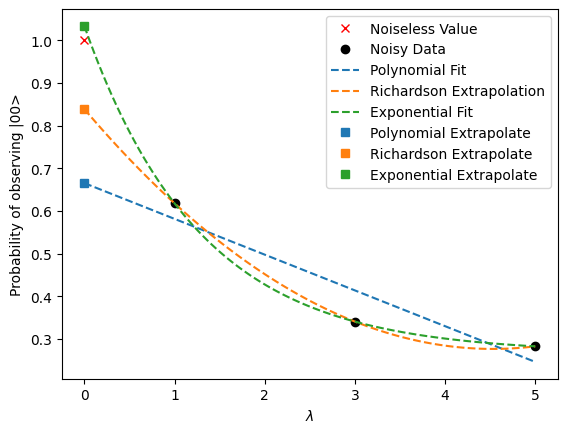

In [16]:
## Plot the ideal data, noisy data, fitted curves, and extrapolated values
plt.figure()
cmap = plt.get_cmap("tab10")
plt.plot([0], ideal_val/numshots, 'rx', label="Noiseless Value") # Ideal value, without noise. 
plt.plot(lambda_vals_tot, measured_vals_tot, 'ko', label="Noisy Data")
plt.plot(xp, p_p(xp), '--', label="Polynomial Fit")
plt.plot(xp, p_RE(xp), '--', label="Richardson Extrapolation")
plt.plot(xp, exp_func(xp, *popt), '--', label="Exponential Fit") # Exponential fit

plt.plot(0, p_p(0), 's', color=cmap(0), label="Polynomial Extrapolate")
plt.plot(0, p_RE(0), 's', color=cmap(1), label="Richardson Extrapolate")
plt.plot(0, exp_func(0, *popt), 's', color=cmap(2), label="Exponential Extrapolate") # Exponential extrapolate
plt.xlabel('$\\lambda$')
plt.ylabel('Probability of observing |' +target_value +'>')
plt.legend()
plt.savefig("ZNE.png", dpi=300)
#plt.plot([0],ideal_val/numshots, 'x', lambda_vals_tot, measured_vals_tot, '.', xp, p(xp), '--')

By inspection of the above figure, we observe that Exponential extrapolation yields the closest error-mitigated estimate of the probability of observing |00>. The true value is 1. 

In [17]:
## Print the ZNE values
print("Using linear extrapolation, the probability is: " + str(p_p(0)))
print("Using Richardson extrapolation, the probability is: " + str(p_RE(0)))
print("Using exponential extrapolation, the probability is: " + str(exp_func(0, *popt)))
print("The true value is 1")

Using linear extrapolation, the probability is: 0.6654333333333335
Using Richardson extrapolation, the probability is: 0.8391249999999985
Using exponential extrapolation, the probability is: 1.0341804386374358
The true value is 1
